In [46]:
from pycocotools.coco import COCO
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [47]:
def get_person_annotations(img_id, coco):
    """
    Estrae tutte le annotazioni di tipo 'person' per una data immagine.
    Get all annotations of Person objects for a given image
    
    Args:
        img_id: COCO dataset image ID
        coco: COCO API instance
    
    Returns:
        Person objects annotations dictionaries list
    """
    person_cat_id = 1
    
    ann_ids = coco.getAnnIds(imgIds=img_id, catIds=[person_cat_id])
    annotations = coco.loadAnns(ann_ids)
    
    return annotations

In [48]:
def process_coco_dataset(annotation_file):
    """
    Processes whole COCO dataset and extracts all Person type annotations.
    
    Args:
        annotation_file: COCO annotations file path
        
    Returns:
        Dictionary with img_id as key and annotations list as value
    """
    coco = COCO(annotation_file)
    
    img_ids = coco.getImgIds()
    
    results = {}
    
    for img_id in img_ids:
        person_annotations = get_person_annotations(img_id, coco)
        if person_annotations: 
            results[img_id] = {
                'image_info': coco.loadImgs(img_id)[0],
                'annotations': person_annotations
            }
    
    return results

In [49]:
def extract_person_details(annotations):
    """
    Extracts detailed informations about people from annotations.
    
    Args:
        annotations: annotations dictionary for an image
        
    Returns:
        List of dictionaries with details for each person
    """
    people = []
    for ann in annotations['annotations']:
        person = {
            'bbox': ann['bbox'],  # [x,y,width,height]
            'area': ann['area'],
            'segmentation': ann['segmentation'],
            'keypoints': ann.get('keypoints', None),
            'confidence': float(ann.get('score', 1.0))
        }
        people.append(person)
    
    return people

In [ ]:
img_width = 640
img_height = 480
img_size = img_width * img_height
annotation_file = 'instances_train2017.json'

results = process_coco_dataset(annotation_file)
number_people = {}
single_person = {}

for img_id, data in results.items():
    people = extract_person_details(data)
    number_people[img_id] = len(people)
    for i, person in enumerate(people, 1):
        single_person[f"{img_id}{i}"] = {'ID': f'{img_id}{i}', 'Img': img_id, 'person_num': i, 'num_people': len(people), 'bbox': person['bbox'], 'area': person['area']}

loading annotations into memory...
Done (t=19.79s)
creating index...
index created!


In [83]:
df = pd.DataFrame.from_dict(single_person, orient='index')
df = df.set_index('ID')

In [84]:
df['x'] = df['bbox'].apply(lambda x: x[0])
df['y'] = df['bbox'].apply(lambda x: x[1])
df['width'] = df['bbox'].apply(lambda x: x[2])
df['height'] = df['bbox'].apply(lambda x: x[3])


In [85]:
df['area_norm'] = df['area']/img_size

In [86]:
df

,Img,person_num,num_people,bbox,area,keypoints,x,y,width,height,area_norm
ID,,,,,,,,,,,
3918951,391895,1,2,"[339.88, 22.16, 153.88, 300.73]",14107.27130,None,339.88,22.16,153.88,300.73,0.045922
3918952,391895,2,2,"[471.64, 172.82, 35.92, 48.1]",708.26055,None,471.64,172.82,35.92,48.10,0.002306
5224181,522418,1,1,"[382.48, 0.0, 256.8, 474.31]",63325.42190,None,382.48,0.00,256.80,474.31,0.206137
1846131,184613,1,14,"[146.48, 65.69, 160.83, 246.9]",11210.37590,None,146.48,65.69,160.83,246.90,0.036492
1846132,184613,2,14,"[8.29, 57.26, 75.33, 146.9]",4457.00885,None,8.29,57.26,75.33,146.90,0.014508
...,...,...,...,...,...,...,...,...,...,...,...
4755462,475546,2,6,"[411.62, 138.47, 73.27, 92.06]",3851.79040,None,411.62,138.47,73.27,92.06,0.012538
4755463,475546,3,6,"[207.8, 131.79, 82.45, 103.34]",5099.04480,None,207.80,131.79,82.45,103.34,0.016598
4755464,475546,4,6,"[110.64, 138.51, 89.53, 103.89]",5632.72470,None,110.64,138.51,89.53,103.89,0.018336


## num_people_diff

In [55]:
def num_peopl_diff(num_people: int):
    return 1-(1/(num_people+1))

In [56]:
def create_df(col_name, col_dimension_name, param_num, dimension):
    return df[(df[col_name]+df[col_dimension_name])<=(param_num*dimension)]

In [57]:
img_df = df[['Img', 'num_people']].groupby('Img').count()
img_df['num_people_diff'] = img_df['num_people'].apply(num_peopl_diff)

#### top 75

In [58]:
top_75_df = create_df('y', 'height', 0.75, img_height)
top_75_df = top_75_df[['Img', 'num_people']].groupby('Img').count()
top_75_df['num_people_diff'] = top_75_df['num_people'].apply(num_peopl_diff)

#### top 25

In [59]:
top_25_df = create_df('y', 'height', 0.25, img_height)
top_25_df = top_25_df[['Img', 'num_people']].groupby('Img').count()
top_25_df['num_people_diff'] = top_75_df['num_people'].apply(num_peopl_diff)

#### top 50

In [60]:
top_50_df = create_df('y', 'height', 0.5, img_height)
top_50_df = top_50_df[['Img', 'num_people']].groupby('Img').count()
top_50_df['num_people_diff'] = top_50_df['num_people'].apply(num_peopl_diff)

#### side 25

In [61]:
side_25_df = create_df('x', 'width', 0.25, img_height)
side_25_df = side_25_df[['Img', 'num_people']].groupby('Img').count()
side_25_df['num_people_diff'] = side_25_df['num_people'].apply(num_peopl_diff)

#### side 50

In [62]:
side_50_df = create_df('x', 'width', 0.5, img_height)
side_50_df = side_50_df[['Img', 'num_people']].groupby('Img').count()
side_50_df['num_people_diff'] = side_50_df['num_people'].apply(num_peopl_diff)

#### side 75

In [63]:
side_75_df = create_df('x', 'width', 0.75, img_width)
side_75_df = side_75_df[['Img', 'num_people']].groupby('Img').count()
side_75_df['num_people_diff'] = side_75_df['num_people'].apply(num_peopl_diff)

In [78]:
def plot_hist(df, title):
    plt.figure(figsize=(10, 6))
    plt.bar(df['num_people_diff'].value_counts().keys(), df['num_people_diff'].value_counts().values, width=0.005, color="skyblue", edgecolor="black")
    plt.xlabel("num_people_diff")
    plt.ylabel("Count")
    plt.title(f"Histogram of {title} num_people_diff Counts")
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.show()

## Plot

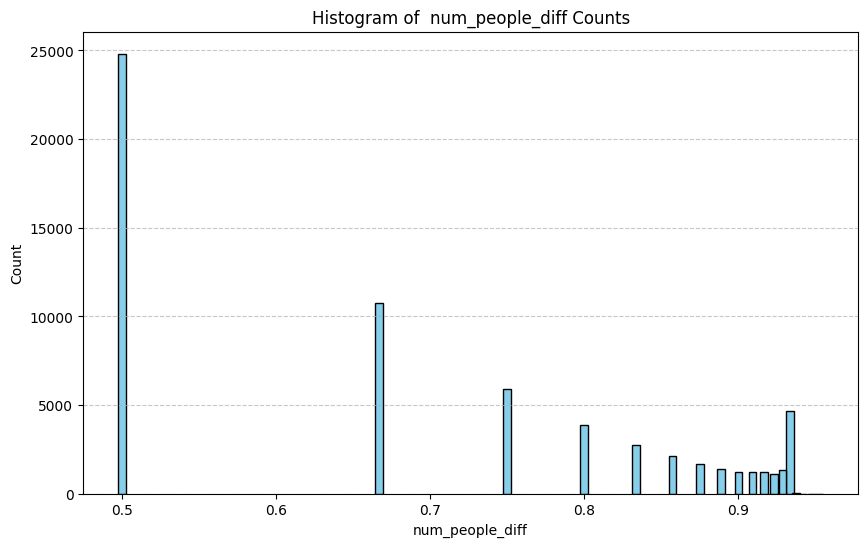

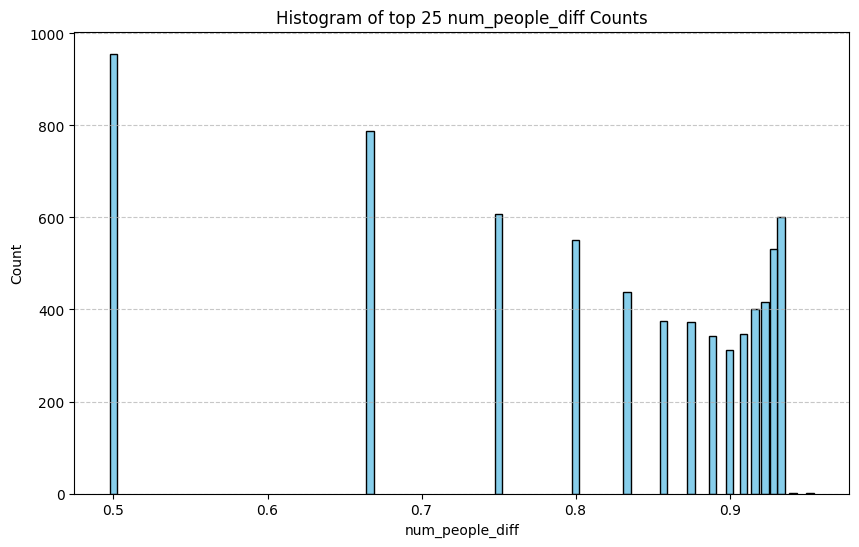

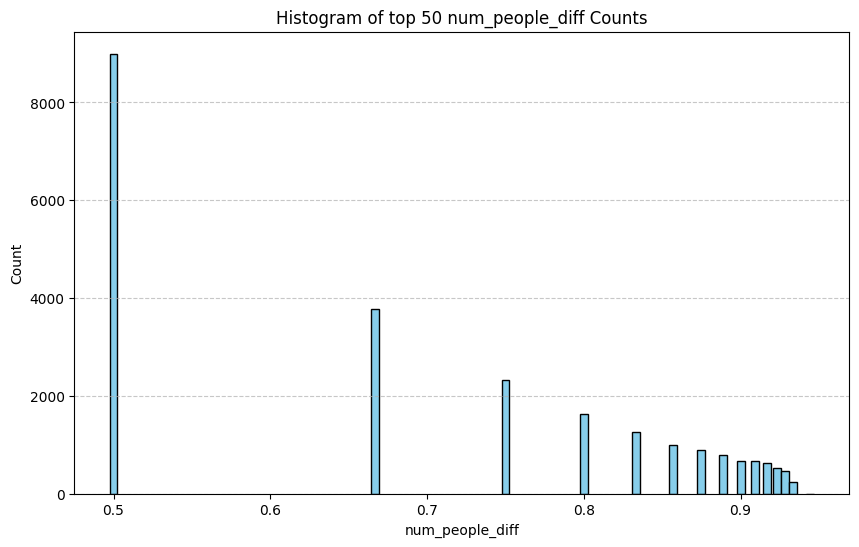

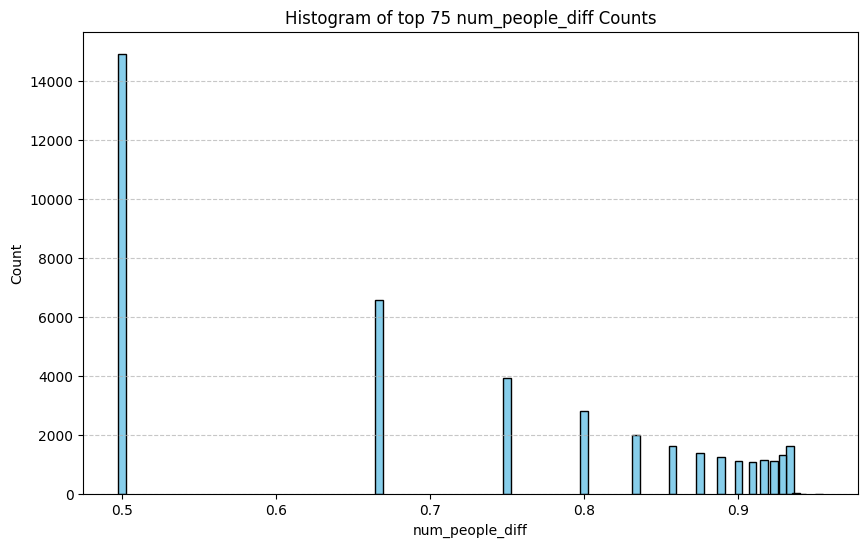

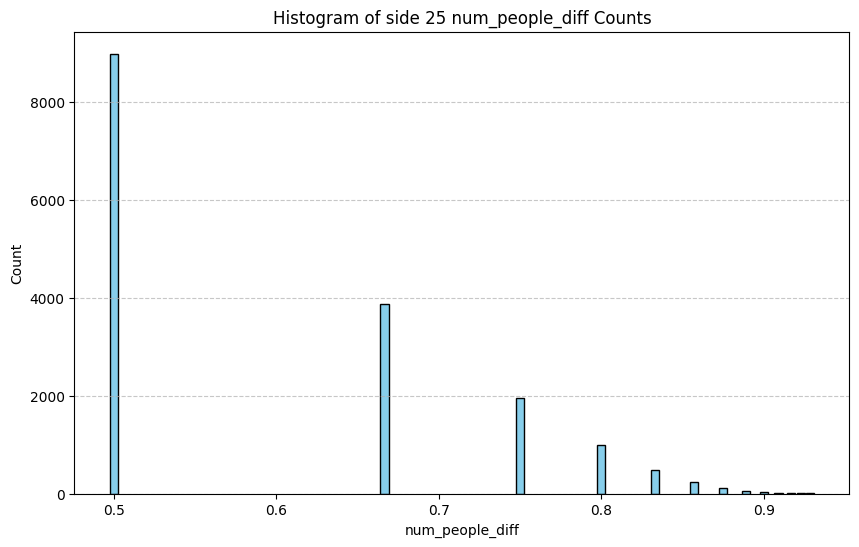

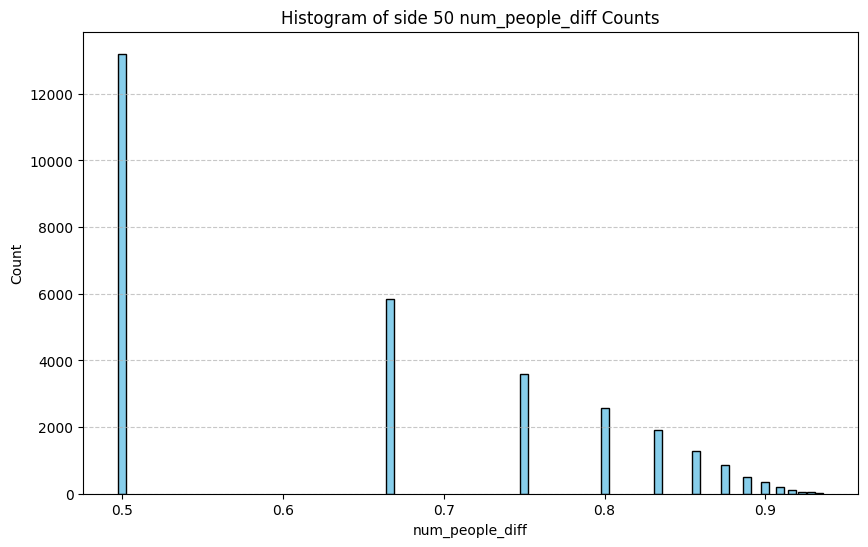

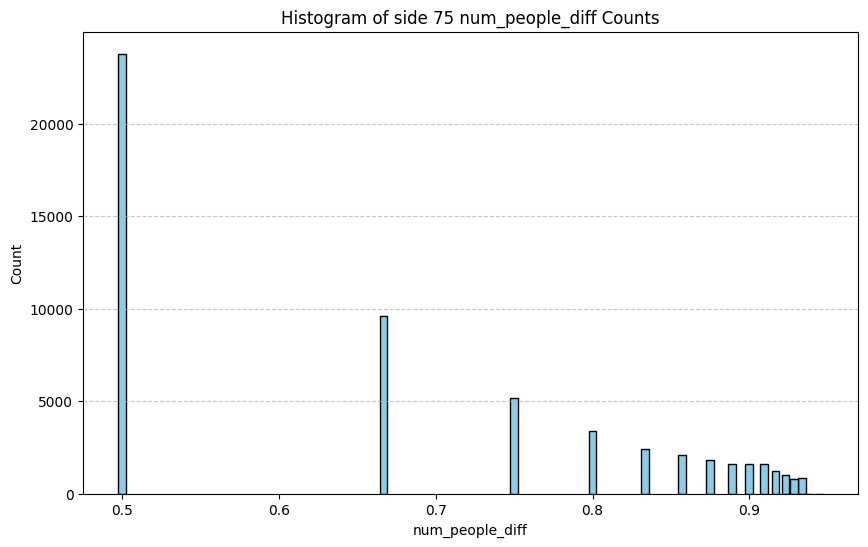

In [80]:
plot_hist(img_df, '')
plot_hist(top_25_df, 'top 25')
plot_hist(top_50_df, 'top 50')
plot_hist(top_75_df, 'top 75')
plot_hist(side_25_df, 'side 25')
plot_hist(side_50_df, 'side 50')
plot_hist(side_75_df, 'side 75')

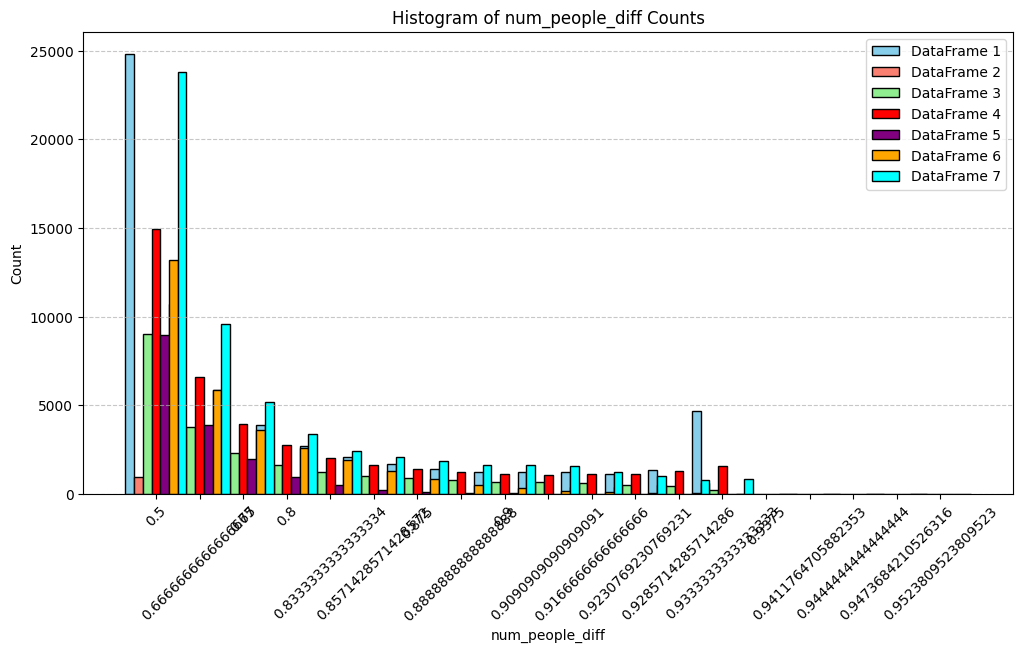

In [81]:
dataframes = [img_df, top_25_df, top_50_df, top_75_df, side_25_df, side_50_df, side_75_df]
colors = ["skyblue", "salmon", "lightgreen", "red", "purple", "orange", "cyan"]

# Calculate unique x-axis labels and their positions
unique_keys = sorted(set().union(*(df_temp['num_people_diff'].unique() for df_temp in dataframes)))
bar_width = 0.2  
x_positions = np.arange(len(unique_keys))  # Base x-positions for each unique key

plt.figure(figsize=(12, 6))

for i, (df_temp, color) in enumerate(zip(dataframes, colors)):
    counts = df_temp['num_people_diff'].value_counts()
    values = [counts.get(key, 0) for key in unique_keys]
    
    offset = (i - (len(dataframes) - 1) / 2) * bar_width
    plt.bar(x_positions + offset, values, width=bar_width, color=color, edgecolor="black", label=f"DataFrame {i+1}")

plt.xlabel("num_people_diff")
plt.ylabel("Count")
plt.title("Histogram of num_people_diff Counts")
plt.xticks(x_positions, unique_keys, rotation=45) 
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.legend()
plt.show()


## people_size_dif

In [72]:
grouped_df = df.groupby('Img').agg({
    'area_norm': 'sum',  
    'num_people': 'count'
})

In [73]:
grouped_df['people_size_diff'] = np.maximum(0, 1-grouped_df['area_norm']/grouped_df['num_people'])

In [74]:
grouped_df

,area_norm,num_people,people_size_diff
Img,,,
36,0.280421,1,0.719579
49,0.012019,6,0.997997
61,0.006486,3,0.997838
74,0.008434,6,0.998594
77,0.051799,5,0.989640
...,...,...,...
581887,0.009368,1,0.990632
581899,0.005494,3,0.998169
581900,0.029597,6,0.995067


In [87]:
top_25_df['people_size_diff'] = np.maximum(0, 1-top_25_df['area_norm']/top_25_df['num_people'])

KeyError: 'area_norm'

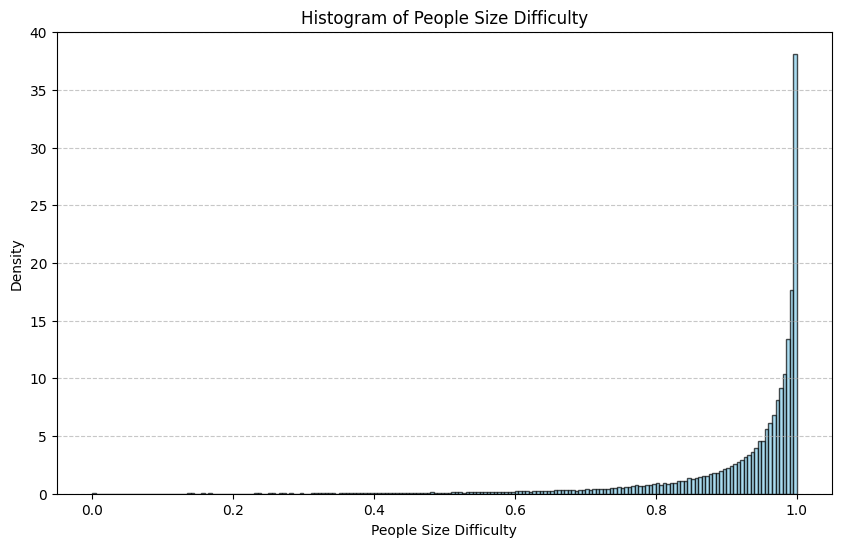

In [75]:
plt.figure(figsize=(10, 6))
plt.hist(grouped_df['people_size_diff'], bins=200, color="skyblue", edgecolor="black", alpha=0.7, density=True)

# Aggiungi etichette e titolo
plt.xlabel("People Size Difficulty")
plt.ylabel("Density")
plt.title("Histogram of People Size Difficulty")

# Aggiungi una griglia
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Mostra l'istogramma
plt.show()